# Judge Hiciano Jupyter Notebook

In [52]:
# Imports required for project
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

# Plotting
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

from pprint import pprint

# sklearn Metrics and tunning
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#import machine learning related libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier

import xgboost as xgb



In [53]:
pd.options.display.max_rows = 50000
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)

## Description of variables
• sessionID: Session ID. 1-50000 in train.csv, 50001-55111 in test.csv.

• hour: Hour when the session was started. Numbers between 0 and 23.

• weekday: Day of the week when the session was started. 5: Friday, 6: Saturday, 7: Sunday, 1: Monday.

• duration: Time in seconds passed since the start of the session.

• clickCount: Number of products that were visited (clicked).

• clickMin: Lowest price of the products visited (clicked).

• clickMax: Highest price of the products visited (clicked).

• clickTotal: Sum of the prices of all the products visited (clicked).

• cartCount: Number of products that were added to the cart.

• cartMin: Lowest price of the products in the cart.

• cartMax: Highest price of the products in the cart.

• cartTotal: Sum of the prices of all the products in the cart.

• cartStep: Purchase processing step. Possible values: 1,2,3,4,5.

• status: Whether the customer is online. ‘y’: yes. ‘n’: no.

• availability: Whether the cart is orderable or not. There are seven possible values.

• customerID: customer ID. 1-25038 in train.csv. In test.csv there exist both old and new customers.

• purchase: Highest purchase price in history for the customer.

• score: Customer score evaluated by the online store.

• account: Lifetime of the customer’s account in months.

• payments: Number of payments made by the customer.

• age: Age of the customer.

• salutation: Salutation of the customer. 1: Mr, 2: Ms, 3: Company.

• lastOrder: Time in days passed since the last order.

• order: (Response variable) Whether the order is placed. ‘y’: yes. ‘n’: no.


In [78]:
df_train = pd.read_csv("../data/train.csv") 
df_test = pd.read_csv("../data/test.csv")

In [50]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45068 entries, 0 to 45067
Data columns (total 23 columns):
sessionID       45068 non-null int64
hour            45068 non-null int64
weekday         45068 non-null int64
duration        45068 non-null float64
clickCount      45068 non-null int64
clickMin        44742 non-null float64
clickMax        44742 non-null float64
clickTotal      44742 non-null float64
cartCount       45068 non-null int64
cartMin         44479 non-null float64
cartMax         44479 non-null float64
cartTotal       44479 non-null float64
cartStep        24302 non-null float64
status          27713 non-null object
availability    27311 non-null object
customerID      27804 non-null float64
purchase        27616 non-null float64
score           27616 non-null float64
account         27616 non-null float64
payments        27804 non-null float64
age             27786 non-null float64
salutation      27804 non-null float64
lastOrder       27804 non-null float64
dtypes

In [70]:
common_drops = ['sessionID',
                'customerID',
                'weekday',
#                 'status',
#                'availability',
#                 'cartStep',
                 'purchase',
#                 'score',                 
                'payments',
                'account',
                'lastOrder',
                 'salutation',
                 'age',
#                 'cartCount',
#                 'clickMin',
#                 'cartMin',
#                 'hour',
                'duration',
#                 'clickCount',
#                 'clickMax',
#                 'cartMax',
#                 'clickTotal',
#                 'cartTotal'
               ]

#common_drops = ['sessionID','hour','weekday','duration','clickTotal']
drop_columns_train = common_drops
drop_columns_submission = common_drops

## Feature Enigneering on Training Data

Currently droping 'order', 'sessionID', and 'age' 

In [110]:
print(len(df_train))
df_train['score'].fillna(-1, inplace=True)
df_train['sess_count'] = df_train.groupby('sessionID')['sessionID'].transform('count')
df_train['customer_total_orders'] = df_train.groupby('customerID')['customerID'].transform('count')
df_train['total_duration'] = df_train.groupby('sessionID')['duration'].transform('sum')
df_train.loc[df_train['customerID'] >= 0,'is_customer'] = 1
df_train['is_customer'].fillna(0, inplace=True)
df_train['cartStep'].fillna(-1, inplace=True)
df_train['missing_items_total'] = df_train['clickTotal']-df_train['cartTotal']
df_train['ordered'] = (df_train['order'] !='n').astype(int) #Converts string `order` to int value for training
df_train['status'] = (df_train['status'] !='n').astype(int) #Converts string `order` to int value for training
df_train = df_train.drop(['availability'], axis=1)
df_train = df_train.drop(['order'], axis=1)
df_train.dropna(thresh=16,inplace=True)
df_train = pd.get_dummies(df_train)
print(len(df_train))
df_train.head(20)

426832


KeyError: 'order'

In [72]:
df_train = df_train.drop(['status_n'], axis=1)
df_train = df_train.drop(['availability_completely not determinable'], axis=1)
df_train = df_train.drop(['availability_mainly not determinable'], axis=1)
df_train = df_train.drop(['availability_mainly not orderable'], axis=1)
df_train = df_train.drop(['availability_mainly orderable'], axis=1)
df_train = df_train.drop(['availability_mixed'], axis=1)

KeyError: "['status_n'] not found in axis"

In [8]:
q = df_train["sess_count"].quantile(0.99)
df_train = df_train[df_train["sess_count"] < q]
df_train.head(2)

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered,status_y,availability_completely not orderable,availability_completely orderable
0,1,6,5,0.000,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,0,0,0
1,1,6,5,11.940,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,1,0,1
2,1,6,5,39.887,1,59.99,59.99,59.99,1,59.99,59.99,59.99,0.0,1.0,600.0,70.0,21.0,1.0,43.0,1.0,49.0,3,3.0,51.827,1.0,0.00,1,1,0,1
8,3,6,5,181.477,9,29.99,29.99,89.97,1,29.99,29.99,29.99,0.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,59.98,1,0,0,0
9,3,6,5,297.018,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,0,0,0
10,3,6,5,310.967,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,1,0,1
11,3,6,5,324.278,11,9.99,29.99,109.95,2,9.99,29.99,39.98,4.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,1,0,1
12,3,6,5,341.613,11,9.99,29.99,109.95,2,9.99,29.99,39.98,0.0,3.0,1800.0,475.0,302.0,12.0,45.0,1.0,11.0,5,5.0,1455.353,1.0,69.97,1,1,0,1
13,4,6,5,28.871,4,4.99,4.99,19.96,1,4.99,4.99,4.99,0.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2,NaN,71.683,0.0,14.97,0,0,0,0
14,4,6,5,42.812,4,4.99,4.99,19.96,1,4.99,4.99,4.99,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2,NaN,71.683,0.0,14.97,0,1,1,0


In [112]:
!pip install lightgbm

     |████████████████████████████████| 1.2 MB 2.0 MB/s eta 0:00:01


In [109]:
sns.pairplot(df_train, hue='ordered')

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

Error in callback <function flush_figures at 0x7f64e720f680> (for post_execute):


KeyboardInterrupt: 

In [80]:
df_train_clensed = df_train.drop(drop_columns_train,axis=1)
#df_train_clensed = pd.get_dummies(df_train_clensed)
#df_train_clensed = df_train_clensed.drop('status_n', axis =1 )
# df_train_clensed.head()
# df_train_clensed.dropna(thresh=4,inplace=True)
df_train_clensed =pd.DataFrame(df_train_clensed).fillna(0)
print(len(df_train_clensed))
df_train_clensed.info()
#df_train_clensed.groupby(by=df_train_clensed.columns, axis=1).sum()
df_train_clensed.head(2)


426832
<class 'pandas.core.frame.DataFrame'>
Int64Index: 426832 entries, 0 to 429012
Data columns (total 18 columns):
hour                     426832 non-null int64
clickCount               426832 non-null int64
clickMin                 426832 non-null float64
clickMax                 426832 non-null float64
clickTotal               426832 non-null float64
cartCount                426832 non-null int64
cartMin                  426832 non-null float64
cartMax                  426832 non-null float64
cartTotal                426832 non-null float64
cartStep                 426832 non-null float64
status                   426832 non-null int64
score                    426832 non-null float64
sess_count               426832 non-null int64
customer_total_orders    426832 non-null float64
total_duration           426832 non-null float64
is_customer              426832 non-null float64
missing_items_total      426832 non-null float64
ordered                  426832 non-null int64
dtypes: floa

,hour,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,score,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered
0,6,1,59.99,59.99,59.99,1,59.99,59.99,59.99,-1.0,1,70.0,3,3.0,51.827,1.0,0.0,1
1,6,1,59.99,59.99,59.99,1,59.99,59.99,59.99,2.0,1,70.0,3,3.0,51.827,1.0,0.0,1


In [10]:
df_train_clensed = df_train_clensed.drop(['customerID'], axis=1)

## Adjust Testing Data Set

In [81]:
df_test['score'].fillna(-1, inplace=True)
df_test['sess_count'] = df_test.groupby('sessionID')['sessionID'].transform('count')
df_test['customer_total_orders'] = df_test.groupby('customerID')['customerID'].transform('count')
df_test['total_duration'] = df_test.groupby('sessionID')['duration'].transform('sum')
df_test.loc[df_test['customerID'] >= 0,'is_customer'] = 1
df_test['is_customer'].fillna(0, inplace=True)
df_test['cartStep'].fillna(0, inplace=True)
df_test = df_test.drop('availability',axis=1)
df_test['missing_items_total'] = df_test['clickTotal']-df_test['cartTotal']
df_test['status'] = (df_test['status'] !='n').astype(int) #Converts string `order` to int value for training
df_test = pd.get_dummies(df_test)
df_test.describe()

,sessionID,hour,weekday,duration,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,customerID,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,44742.000000,44742.000000,44742.000000,45068.000000,44479.000000,44479.000000,44479.000000,45068.000000,45068.000000,27804.000000,27616.000000,45068.000000,27616.000000,27804.000000,27786.000000,27804.000000,27804.000000,45068.000000,27804.000000,4.506800e+04,45068.000000,44479.000000
mean,52385.701185,18.589509,6.458418,1645.291183,27.316810,53.299304,149.135132,1240.985675,4.366668,65.935684,105.750478,209.595122,1.208330,0.995141,25236.189433,2039.006373,294.743033,129.780997,9.951014,43.281941,1.744497,94.915264,17.163486,19.906272,3.847433e+04,0.616934,1033.120793
std,1426.206838,5.543531,1.719373,2279.003964,32.549188,146.774665,272.250373,3523.665302,4.333860,172.340996,204.394800,414.707600,1.462052,0.069540,4087.158333,2157.553606,259.960288,104.308406,13.388516,11.526591,0.439028,125.050807,13.240240,18.701953,7.956577e+04,0.486139,3272.518633
min,50001.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.000000,0.000000,-1.000000,0.000000,0.000000,17.000000,1.000000,4.000000,1.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,51166.000000,19.000000,7.000000,259.884500,6.000000,5.000000,29.990000,154.370000,1.000000,7.990000,19.990000,39.990000,0.000000,1.000000,25478.000000,600.000000,-1.000000,43.000000,2.000000,35.000000,1.000000,16.000000,8.000000,10.000000,3.768789e+03,0.000000,79.940000
50%,52331.000000,20.000000,7.000000,864.808000,15.000000,9.990000,49.990000,445.540000,3.000000,12.990000,34.990000,89.970000,1.000000,1.000000,26090.000000,1200.000000,457.000000,102.000000,7.000000,43.000000,2.000000,42.000000,14.000000,16.000000,1.373283e+04,1.000000,313.830000
75%,53600.000000,21.000000,7.000000,2148.555000,36.000000,24.990000,99.990000,1164.570000,6.000000,29.990000,69.990000,209.850000,2.000000,1.000000,26681.000000,3000.000000,537.000000,213.000000,13.000000,50.000000,2.000000,123.000000,22.000000,24.000000,4.018059e+04,1.000000,933.250000
max,55111.000000,23.000000,7.000000,21320.113000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,1.000000,27318.000000,25000.000000,614.000000,524.000000,278.000000,90.000000,3.000000,733.000000,87.000000,187.000000,1.172623e+06,1.000000,108950.790000


In [82]:
df_test_cl = df_test.drop(drop_columns_submission,axis=1)
df_test_cl = pd.get_dummies(df_test_cl)
df_test_cl = pd.DataFrame(df_test_cl).fillna(-1)
len(df_test_cl)
df_test_cl.head()

,hour,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,score,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total
0,18,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,1,489.0,9,9.0,3761.542,1.0,39.99
1,18,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,1,489.0,9,9.0,3761.542,1.0,39.99
2,18,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,1,489.0,9,9.0,3761.542,1.0,56.98
3,18,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,1,489.0,9,9.0,3761.542,1.0,74.97
4,18,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,1,489.0,9,9.0,3761.542,1.0,94.96


In [25]:
df_test_cl = df_test_cl.drop(['availability_completely not determinable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly not determinable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly not orderable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mainly orderable'], axis=1)
df_test_cl = df_test_cl.drop(['availability_mixed'], axis=1)

In [84]:
df_test_cl.head()

,hour,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,score,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total
0,18,3,39.99,39.99,79.98,1,39.99,39.99,39.99,2.0,1,489.0,9,9.0,3761.542,1.0,39.99
1,18,3,39.99,39.99,79.98,1,39.99,39.99,39.99,0.0,1,489.0,9,9.0,3761.542,1.0,39.99
2,18,6,16.99,39.99,113.96,2,16.99,39.99,56.98,0.0,1,489.0,9,9.0,3761.542,1.0,56.98
3,18,8,16.99,39.99,149.94,3,16.99,39.99,74.97,0.0,1,489.0,9,9.0,3761.542,1.0,74.97
4,18,10,16.99,39.99,189.92,4,16.99,39.99,94.96,0.0,1,489.0,9,9.0,3761.542,1.0,94.96


In [83]:
df_test_cl.describe()

,hour,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,score,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total
count,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,45068.000000,4.506800e+04,45068.000000,45068.000000
mean,18.589509,27.316810,52.906529,148.049127,1232.001755,4.366668,65.060892,104.355341,206.842825,1.208330,0.995141,294.743033,17.163486,11.897799,3.847433e+04,0.616934,1019.605723
std,5.543531,32.549188,146.315215,271.562102,3512.474872,4.333860,171.379781,203.416366,412.682372,1.462052,0.069540,259.960288,13.240240,17.862583,7.956577e+04,0.486139,3253.184070
min,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000,-1.000000,0.000000e+00,0.000000,-1.000000
25%,19.000000,6.000000,5.000000,29.950000,149.957500,1.000000,7.000000,19.990000,39.980000,0.000000,1.000000,-1.000000,8.000000,-1.000000,3.768789e+03,0.000000,70.315000
50%,20.000000,15.000000,9.990000,49.990000,438.780000,3.000000,12.990000,34.990000,87.985000,1.000000,1.000000,457.000000,14.000000,9.000000,1.373283e+04,1.000000,304.920000
75%,21.000000,36.000000,24.990000,99.990000,1159.840000,6.000000,29.990000,69.990000,205.900000,2.000000,1.000000,537.000000,22.000000,18.000000,4.018059e+04,1.000000,917.885000
max,23.000000,200.000000,1999.990000,4799.000000,117310.700000,43.000000,1999.990000,2299.990000,8948.960000,5.000000,1.000000,614.000000,87.000000,187.000000,1.172623e+06,1.000000,108950.790000


In [85]:
q = df_train_clensed["sess_count"].quantile(0.99)
df_train_clensed = df_train_clensed[df_train_clensed["sess_count"] < q]
df_train_clensed.describe()

,hour,clickCount,clickMin,clickMax,clickTotal,cartCount,cartMin,cartMax,cartTotal,cartStep,status,score,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,ordered
count,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000,422494.000000
mean,14.626646,23.892387,55.148454,145.067695,1152.431961,4.027920,67.054145,105.460060,203.599790,0.817813,0.993396,312.121663,15.900588,15.762884,32353.399182,0.650480,938.767045,0.676651
std,4.472395,29.978841,148.828414,281.458134,3098.981354,3.988807,174.280544,210.109153,410.871446,1.901584,0.080994,255.560643,11.363610,68.732219,62313.569835,0.476819,2856.575813,0.467755
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,5.000000,6.990000,24.990000,135.150000,1.000000,8.990000,19.990000,39.980000,-1.000000,1.000000,-1.000000,8.000000,0.000000,3032.423250,0.000000,59.980000,0.000000
50%,15.000000,12.000000,12.000000,49.990000,381.790000,3.000000,14.990000,39.900000,84.980000,1.000000,1.000000,475.000000,13.000000,9.000000,11063.548500,1.000000,262.900000,1.000000
75%,18.000000,30.000000,29.990000,99.990000,1026.670000,5.000000,34.990000,74.950000,199.990000,2.000000,1.000000,536.000000,21.000000,18.000000,33976.699000,1.000000,799.980000,1.000000
max,23.000000,200.000000,5999.990000,6999.990000,104519.050000,46.000000,6999.990000,6999.990000,23116.880000,5.000000,1.000000,638.000000,72.000000,1248.000000,980431.326000,1.000000,103199.070000,1.000000


In [86]:
#df_test_cl = df_test_cl.drop('customerID',axis=1)
#df_train_clensed = df_train_clensed.drop('customerID',axis=1)
column_order = []
for col in df_train_clensed.columns: 
    column_order.append(col)
print(column_order)
column_order.remove('ordered')
df_test_cl = df_test_cl[column_order]


['hour', 'clickCount', 'clickMin', 'clickMax', 'clickTotal', 'cartCount', 'cartMin', 'cartMax', 'cartTotal', 'cartStep', 'status', 'score', 'sess_count', 'customer_total_orders', 'total_duration', 'is_customer', 'missing_items_total', 'ordered']


## Create training and testing datasets

In [87]:
X, y = df_train_clensed.drop(['ordered'],axis=1), df_train_clensed.ordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=68)

In [32]:
#create an array of models as base to see what has highest base score to select for tuning
models = []

# models.append(("RF",RandomForestClassifier()))
# models.append(("RF Tunned",RandomForestClassifier(max_depth = 35,
#                                                   n_estimators= 40,
#                                                   random_state=0,
#                                                   max_features='auto',
#                                                   bootstrap=False,
#                                                   min_samples_leaf=1,
#                                                   min_samples_split=2)))
# models.append(("Ada",AdaBoostClassifier()))
# models.append(("XGB",xgb.XGBClassifier()))
models.append(("Bagging",BaggingClassifier()))
models.append(("Gradient",GradientBoostingClassifier()))
models.append(("Hist",HistGradientBoostingClassifier,GradientBoostingClassifier()))


#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=7, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

Bagging [0.96073096 0.95756628 0.95681371 0.95523137 0.95449809 0.96047934
 0.95627255]
Gradient [0.79659218 0.79018564 0.79325383 0.7922504  0.79255914 0.79259374
 0.79396384]


ValueError: too many values to unpack (expected 2)

Source for Parameter running randomforest:
    
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

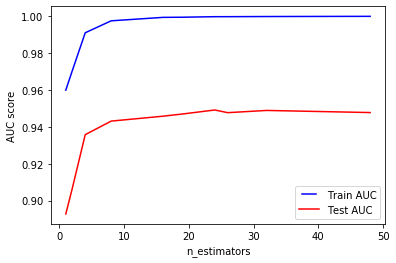

In [100]:
from sklearn.metrics import roc_curve, auc
n_estimators = [1, 2, 4, 8, 16, 19,24,26, 32,48]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

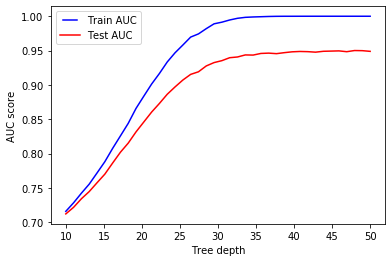

In [101]:
max_depths = np.linspace(10, 50, 40, endpoint=True)
train_results = []
test_results = []

# Loop through each of the max depths and train
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results,'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [119]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3,4,5, 10,]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
oob_score=[True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score
              }


In [120]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rc_random = RandomizedSearchCV(estimator = rc,
                               param_distributions = random_grid,
                               n_iter = 25,
                               cv = 7,
                               verbose=5,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rc_random.fit(X_train, y_train)

Fitting 7 folds for each of 25 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 9 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 22.6min finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [121]:
rc_random.best_params_

{'oob_score': True,
 'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 34,
 'bootstrap': True}

In [62]:
clf2 = RandomForestClassifier(
                              oob_score=True,
                              max_depth = 34,
                              n_estimators=40,
                              random_state=0,
                              max_features='auto',
                              bootstrap=True,
                              min_samples_leaf=1,
                              min_samples_split=2)

In [37]:
multi_target_forest = MultiOutputClassifier(clf2, n_jobs=-1)

In [100]:
clf2 = BaggingClassifier(oob_score=True,
                              n_estimators= 40,
                              random_state=0,
                              bootstrap=True)

In [111]:
X_train.head()

,clickCount,clickMin,clickMax,cartCount,cartMin,cartMax,cartTotal,cartStep,purchase,score,account,payments,age,salutation,lastOrder,sess_count,customer_total_orders,total_duration,is_customer,missing_items_total,status_y,availability_completely not orderable,availability_completely orderable
278940,12,9.99,47.99,1,14.99,14.99,14.99,2.0,11400.0,533.0,128.0,52.0,38.0,2.0,4.0,5,5.0,2873.313,1.0,120.96,1,0,1
290063,10,24.99,99.99,1,24.99,24.99,24.99,1.0,600.0,559.0,70.0,22.0,27.0,2.0,14.0,6,6.0,1627.568,1.0,299.91,1,0,1
73780,7,7.99,24.99,5,7.99,24.99,77.95,0.0,2500.0,525.0,221.0,17.0,48.0,2.0,29.0,22,22.0,8013.668,1.0,15.98,0,0,0
135593,37,3.99,29.99,6,5.99,19.99,33.97,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,25,-1.0,53444.533,0.0,432.35,0,0,0
228000,9,9.99,29.99,9,9.99,29.99,172.91,0.0,4000.0,560.0,142.0,15.0,49.0,2.0,10.0,34,34.0,35362.259,1.0,0.00,0,0,0


In [102]:
clf2.fit(X_train, y_train)
#print(clf2.feature_importances_)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=40,
                  n_jobs=None, oob_score=True, random_state=0, verbose=0,
                  warm_start=False)

In [89]:
# multi_target_forest.fit((X_train, y_train).predict(X)

In [ ]:
features = X_train.columns.values
importances = clf2.feature_importances_
indices = np.argsort(importances)
pprint(clf2.get_params())
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [103]:
clf2.score(X_test, y_test)

0.9704457593688363

In [121]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

lgb_train=lgb.Dataset(X_train, y_train)
lgb_eval=lgb.Dataset(X_test, y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

#print('The rmse of prediction is:', accuracy_score(y_test, y_pred))
y_pred

Starting training...
[1]	valid_0's l1: 0.431262	valid_0's l2: 0.212655
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.425217	valid_0's l2: 0.207068
[3]	valid_0's l1: 0.419497	valid_0's l2: 0.202035
[4]	valid_0's l1: 0.414014	valid_0's l2: 0.197435
[5]	valid_0's l1: 0.408837	valid_0's l2: 0.193306
[6]	valid_0's l1: 0.403884	valid_0's l2: 0.189525
[7]	valid_0's l1: 0.399172	valid_0's l2: 0.186073
[8]	valid_0's l1: 0.394711	valid_0's l2: 0.182983
[9]	valid_0's l1: 0.390442	valid_0's l2: 0.180137
[10]	valid_0's l1: 0.386415	valid_0's l2: 0.177586
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 0.386415	valid_0's l2: 0.177586
Saving model...
Starting predicting...
The rmse of prediction is: 0.4214094324891985


array([0.60181634, 0.57122702, 0.67911569, ..., 0.7579211 , 0.70008945,
       0.73137514])

In [104]:
results = clf2.predict(df_test_cl)

## Get results as csv

1. I create a dataframe with the sessionsID from the test dataset and join it to the results to get a dataframe `"sessionId","order"`. Then we have to  flatten the sessionIds are we get duplicates. 
1. I  sort by order , 1s would be first for a given session ID and then drop all the duplicates
1. I then convert the 1 to y and 0 to n for oder
1. last step is writing out to a csv file

In [105]:
df_results = pd.DataFrame({"sessionID":df_test.sessionID, "order_int":results})
df_results.sort_values(by=['order_int'], ascending=False)
df_dist  = df_results.drop_duplicates(subset = "sessionID", )
df_dist.head()

,sessionID,order_int
0,50001,1
9,50002,1
20,50003,1
43,50004,0
49,50005,0


In [107]:
df_dist.loc[df_dist['order_int']==1,'order'] = 'y'
df_dist['order'].fillna('n', inplace=True)
df_final = df_dist.drop('order_int',axis=1)
df_final.head()

,sessionID,order
0,50001,y
9,50002,y
20,50003,y
43,50004,n
49,50005,n


In [108]:
df_final.to_csv("../data/results.csv", index=False)

Automatically created module for IPython interactive environment


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

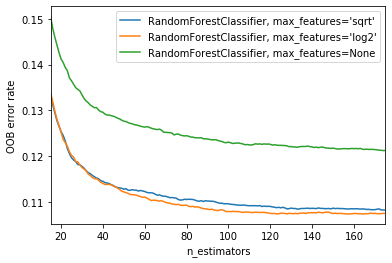

In [100]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 30
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()